# PyMC model

This notebook shows a PyMC model that incorporates basket + clustering

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
from os.path import exists

sys.path.append('..')
sys.path.append('.')

In [3]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from sklearn.metrics import mean_squared_error
import math
from statsmodels.formula.api import glm
import statsmodels.api as sm
import seaborn as sns

from scipy import stats
from scipy.special import expit as logistic

In [4]:
from pyBasket.common import load_obj
from pyBasket.model import get_model_simple, get_model_bhm, get_model_bhm_nc, get_model_logres, get_model_logres_nc

## 1. GDSCv2 analysis

### Load expression data

In [5]:
data_dir = os.path.abspath(os.path.join('..', 'Data'))
data_dir

'/Users/joewandy/Work/git/pyBasket/Data'

The data consists of 446 samples x 19957 transcripts

In [6]:
expr_file = os.path.join(data_dir, 'GDSCv2.exprsALL.tsv')
df = pd.read_csv(expr_file, sep='\t')
expr_df = df.drop(df.index[-25:]).transpose()
expr_df

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.12,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,...,ENSG00000288436.1,ENSG00000288460.1,ENSG00000288520.1,ENSG00000288529.1,ENSG00000288534.1,ENSG00000288547.1,ENSG00000288550.1,ENSG00000288558.1,ENSG00000288564.1,ENSG00000288570.1
TGBC24TKB,3.842223,-5.465508,6.643472,2.413681,3.523928,-6.722421,1.493328,5.312851,7.657224,4.241038,...,-9.965784,-6.590911,-9.965784,-9.965784,3.498175,-9.965784,-0.647309,1.826165,-5.399761,-9.965784
EGI-1,5.477477,-3.712215,5.685061,3.274900,3.243179,-4.146015,4.508079,4.801951,4.677299,4.812610,...,-5.393783,-6.552767,-4.030988,-9.965784,2.821231,-9.965784,-1.324475,1.050212,-3.380326,-9.965784
TGBC1TKB,5.247886,-5.464387,6.443945,2.174270,4.884496,-3.860326,-2.119720,6.585122,7.530231,4.834777,...,-3.459260,-9.965784,-6.932179,-9.965784,2.675651,-3.173723,-2.442109,1.872312,-2.986262,-9.965784
ETK-1,5.772839,-5.669225,6.345230,2.088130,4.272358,-6.904595,2.426256,6.914759,6.597911,4.163071,...,-3.497535,-6.780472,-3.047387,-9.965784,3.500665,-9.965784,-1.753472,1.533735,-3.042083,-9.965784
SW1710,3.891433,-6.720904,6.461246,2.432792,3.541814,-6.584625,4.976817,5.593969,4.455942,5.065822,...,-2.528606,-5.514698,-4.137394,-9.965784,3.020995,-1.689065,-1.219231,1.743528,-1.304345,-9.965784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ASH-3,3.230687,-9.965784,6.793055,2.174138,2.815748,-6.168741,3.105009,4.966726,4.675848,4.668331,...,-9.965784,-9.965784,-9.965784,-9.965784,1.998570,-9.965784,-0.486651,0.090239,-1.683468,-9.965784
KMH-2,2.644470,-9.965784,7.369643,2.521319,4.211213,-9.965784,1.926462,5.212597,3.104173,3.763338,...,-6.705062,-9.965784,-1.975997,-9.965784,2.052412,-9.965784,-0.561202,-0.021777,-2.262192,-9.965784
HTC-C3,4.297403,-9.965784,6.790183,1.780538,2.229505,-2.115773,3.557124,4.339450,4.492282,4.175475,...,-9.965784,-6.805531,-9.965784,-9.965784,1.023656,-9.965784,-1.808425,0.997827,-2.137166,-9.965784
IHH-4,2.770616,-5.795143,5.490973,3.801877,4.603189,-2.927377,-3.172772,-0.264386,4.179838,4.530007,...,-2.538738,-5.954484,-9.965784,-9.965784,1.825162,-9.965784,-2.307655,1.466204,-2.971226,-9.965784


Each sample is assigned to one tissue

In [7]:
tissue_df = df.tail(25).astype(int).transpose()
tissue_df

,CNS/Brain,Bone,Prostate,Esophagus/Stomach,Bladder/Urinary Tract,Ovary/Fallopian Tube,Lymphoid,Kidney,Thyroid,Soft Tissue,...,Uterus,Pancreas,Breast,Cervix,Bowel,Peripheral Nervous System,Liver,Biliary Tract,Other,Ampulla of Vater
TGBC24TKB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
EGI-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
TGBC1TKB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
ETK-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
SW1710,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ASH-3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
KMH-2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
HTC-C3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
IHH-4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
flat_list = tissue_df.reset_index().melt(id_vars='index', var_name='tissue', value_name='belongs_to_tissue')
flat_list = flat_list[flat_list['belongs_to_tissue'] != 0]

# set the index to the sample name
flat_list = flat_list.set_index('index')

# create the dictionary
sample_dict = flat_list['tissue'].to_dict()

In [9]:
tissues = np.array([sample_dict[s] for s in expr_df.index.values])
tissues[0:10]

array(['Biliary Tract', 'Biliary Tract', 'Biliary Tract', 'Biliary Tract',
       'Bladder/Urinary Tract', 'Bladder/Urinary Tract',
       'Bladder/Urinary Tract', 'Bladder/Urinary Tract',
       'Bladder/Urinary Tract', 'Bone'], dtype='<U25')

Do PCA and colour by basket (tissues)

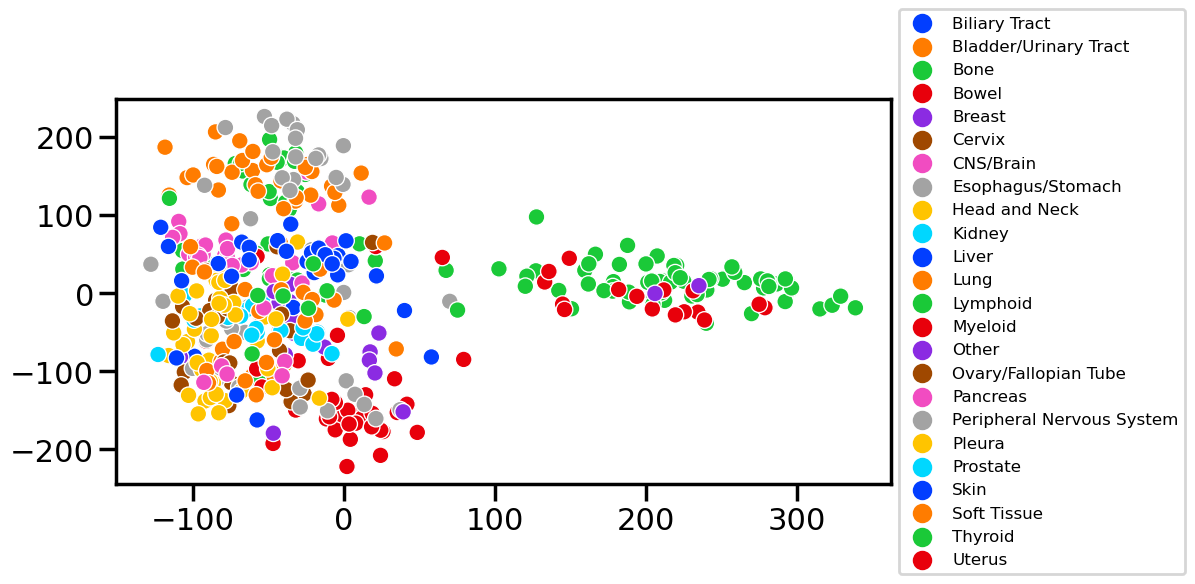

PCA explained variance [0.12949628 0.22238095 0.28729125 0.32075101 0.34293046 0.36347672
 0.38132787 0.39535593 0.40877641 0.42098261]


In [10]:
from sklearn.decomposition import PCA

# Create a PCA object with the number of components you want to keep
n_components = 10
pca = PCA(n_components=n_components)
pcs = pca.fit_transform(expr_df)
pc1_values = pcs[:, 0]
pc2_values = pcs[:, 1]

sns.set_context('poster')
plt.figure(figsize=(10, 5))
g = sns.scatterplot(x=pc1_values, y=pc2_values, hue=tissues, palette='bright')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=12)
plt.show()
print('PCA explained variance', pca.explained_variance_ratio_.cumsum())

### Load drug responses data

Each sample also has its corresponding drug response. There are 11 drugs.
Not sure why there are 1104 samples?

In [11]:
response_file = os.path.join(data_dir, 'GDSCv2.aacALL.tsv')
response_df = pd.read_csv(response_file, sep='\t').transpose()
response_df

,Bortezomib,Entinostat,Sirolimus,Docetaxel,Gemcitabine,Crizotinib,Lapatinib,Vorinostat,Erlotinib,Paclitaxel,Pictilisib
143B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22Rv1,0.184836,0.142503,0.304184,0.111977,0.596289,0.077036,0.048663,0.240865,0.069736,0.015539,0.254125
23132/87,0.228235,0.121580,0.208475,0.232821,0.407328,0.018921,0.172438,0.235145,0.124366,0.025982,0.431203
380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
YH-13,0.174638,0.019992,0.157624,0.211467,0.359880,0.008977,0.069979,0.144077,0.108331,0.087400,0.349741
YKG-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YMB-1-E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YT,0.230123,NaN,0.212004,0.113564,0.666782,NaN,0.084477,0.235547,0.000000,0.000000,0.172903


In [12]:
response_df.loc['TGBC24TKB']

Bortezomib     0.046804
Entinostat     0.074151
Sirolimus      0.015096
Docetaxel      0.229496
Gemcitabine    0.410541
Crizotinib     0.000000
Lapatinib      0.239909
Vorinostat     0.181613
Erlotinib      0.128392
Paclitaxel     0.014104
Pictilisib     0.387379
Name: TGBC24TKB, dtype: float64

### Collect the samples and responses for 'Bortezomib'

In [13]:
samples = tissue_df.index.values
response_dict = response_df['Bortezomib'].to_dict()
responses = np.array([response_dict[s] for s in samples])
len(samples), len(responses), len(tissues)

(446, 446, 446)

In [14]:
df = pd.DataFrame({
    'tissues': tissues,
    'samples': samples,    
    'responses': responses
})
df

,tissues,samples,responses
0,Biliary Tract,TGBC24TKB,0.046804
1,Biliary Tract,EGI-1,0.172105
2,Biliary Tract,TGBC1TKB,0.180130
3,Biliary Tract,ETK-1,0.175669
4,Bladder/Urinary Tract,SW1710,0.235879
...,...,...,...
441,Thyroid,ASH-3,0.239005
442,Thyroid,KMH-2,NaN
443,Thyroid,HTC-C3,0.296591
444,Thyroid,IHH-4,0.099876


### Drop all the NaN responses

In [15]:
df = df.dropna(subset=['responses'])
df

,tissues,samples,responses
0,Biliary Tract,TGBC24TKB,0.046804
1,Biliary Tract,EGI-1,0.172105
2,Biliary Tract,TGBC1TKB,0.180130
3,Biliary Tract,ETK-1,0.175669
4,Bladder/Urinary Tract,SW1710,0.235879
...,...,...,...
440,Thyroid,WRO,0.079241
441,Thyroid,ASH-3,0.239005
443,Thyroid,HTC-C3,0.296591
444,Thyroid,IHH-4,0.099876


In [16]:
df['tissues'].unique()

array(['Biliary Tract', 'Bladder/Urinary Tract', 'Bone', 'Bowel',
       'Breast', 'Cervix', 'CNS/Brain', 'Esophagus/Stomach',
       'Head and Neck', 'Kidney', 'Liver', 'Lung', 'Lymphoid', 'Myeloid',
       'Other', 'Ovary/Fallopian Tube', 'Pancreas',
       'Peripheral Nervous System', 'Pleura', 'Prostate', 'Skin',
       'Soft Tissue', 'Thyroid', 'Uterus'], dtype=object)

In [17]:
df.groupby('tissues').count()

,samples,responses
tissues,,
Biliary Tract,4,4
Bladder/Urinary Tract,5,5
Bone,25,25
Bowel,28,28
Breast,11,11
CNS/Brain,14,14
Cervix,13,13
Esophagus/Stomach,19,19
Head and Neck,16,16


In [18]:
df['responses'].max(), df['responses'].min()

(0.441171871256905, 0.0066721853284744)

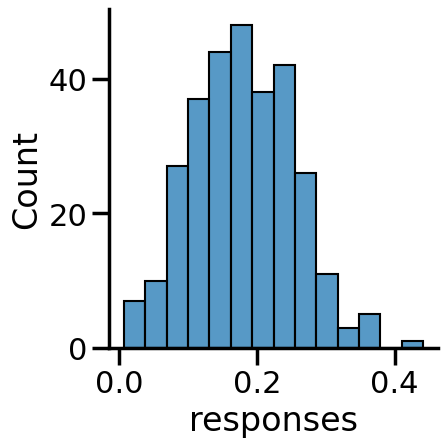

In [19]:
sns.displot(df['responses'])

In [20]:
df['responses'].mean()

0.17974956979291523

#### Select a few baskets for analysis

In [21]:
# basket_names = [
#     'Lymphoid',
#     'Bowel',
#     'Bone',
#     'Lung',
#     'Esophagus/Stomach'
# ]

In [22]:
basket_names = df['tissues'].unique()
basket_names

array(['Biliary Tract', 'Bladder/Urinary Tract', 'Bone', 'Bowel',
       'Breast', 'Cervix', 'CNS/Brain', 'Esophagus/Stomach',
       'Head and Neck', 'Kidney', 'Liver', 'Lung', 'Lymphoid', 'Myeloid',
       'Other', 'Ovary/Fallopian Tube', 'Pancreas',
       'Peripheral Nervous System', 'Pleura', 'Prostate', 'Skin',
       'Soft Tissue', 'Thyroid', 'Uterus'], dtype=object)

In [23]:
df_filtered = df[df['tissues'].isin(basket_names)].reset_index(drop=True)
df_filtered

,tissues,samples,responses
0,Biliary Tract,TGBC24TKB,0.046804
1,Biliary Tract,EGI-1,0.172105
2,Biliary Tract,TGBC1TKB,0.180130
3,Biliary Tract,ETK-1,0.175669
4,Bladder/Urinary Tract,SW1710,0.235879
...,...,...,...
294,Thyroid,WRO,0.079241
295,Thyroid,ASH-3,0.239005
296,Thyroid,HTC-C3,0.296591
297,Thyroid,IHH-4,0.099876


In [24]:
sample_list = df_filtered['samples'].tolist()
expr_df_filtered = expr_df[expr_df.index.isin(sample_list)]
expr_df_filtered.shape, expr_df.shape

((299, 19957), (446, 19957))

### Do PCA again on these samples

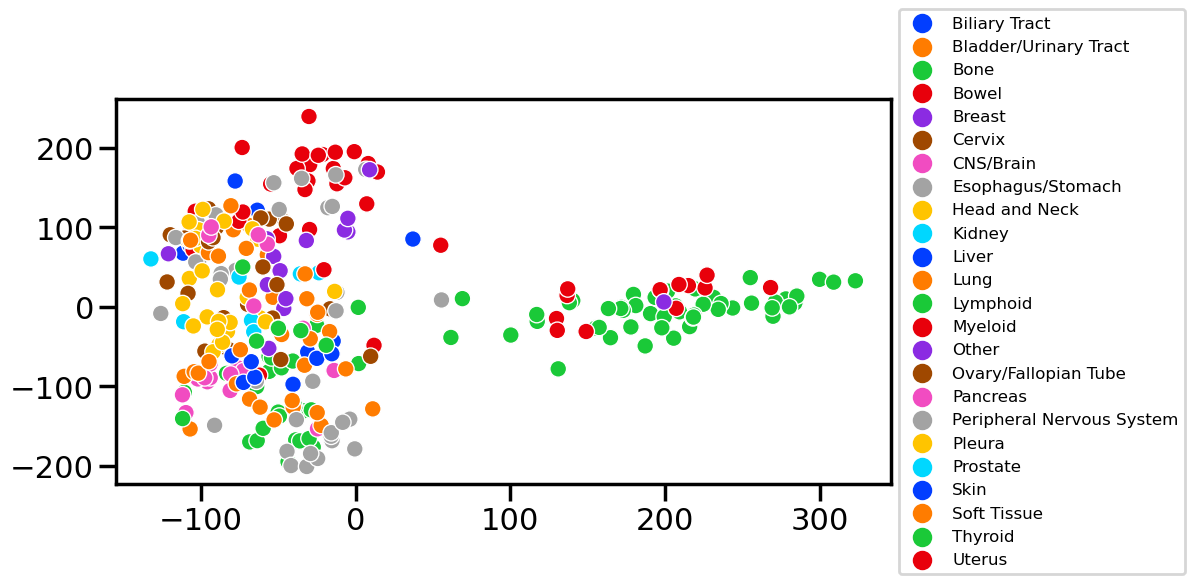

PCA explained variance [0.13785045 0.22932835 0.28970507 0.32243163 0.34542491 0.36526569
 0.38060368 0.39520102 0.40855131 0.42052822]


In [25]:
from sklearn.decomposition import PCA

# Create a PCA object with the number of components you want to keep
n_components = 10
pca = PCA(n_components=n_components)
pcs = pca.fit_transform(expr_df_filtered)
pc1_values = pcs[:, 0]
pc2_values = pcs[:, 1]

sns.set_context('poster')
plt.figure(figsize=(10, 5))
g = sns.scatterplot(x=pc1_values, y=pc2_values, hue=df_filtered['tissues'].values, palette='bright')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=12)
plt.show()
print('PCA explained variance', pca.explained_variance_ratio_.cumsum())

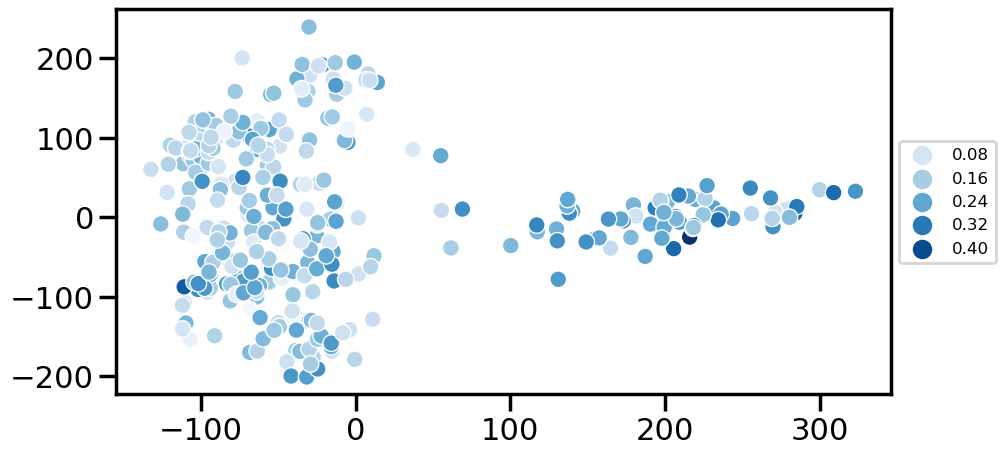

In [26]:
plt.figure(figsize=(10, 5))
g = sns.scatterplot(x=pc1_values, y=pc2_values, hue=df_filtered['responses'].values, palette='Blues')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=12)

### Try clustering

In [27]:
expr_df_filtered.shape

(299, 19957)

In [28]:
classes = df_filtered.set_index('samples')
classes

,tissues,responses
samples,,
TGBC24TKB,Biliary Tract,0.046804
EGI-1,Biliary Tract,0.172105
TGBC1TKB,Biliary Tract,0.180130
ETK-1,Biliary Tract,0.175669
SW1710,Bladder/Urinary Tract,0.235879
...,...,...
WRO,Thyroid,0.079241
ASH-3,Thyroid,0.239005
HTC-C3,Thyroid,0.296591


In [29]:
C = 5

In [30]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=C, random_state=42)
kmeans.fit(expr_df_filtered)

cluster_labels = kmeans.labels_
# df['cluster'] = cluster_labels

cluster_labels

array([0, 2, 2, 2, 3, 2, 3, 2, 2, 3, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4, 3,
       3, 4, 4, 3, 4, 3, 4, 4, 3, 4, 4, 3, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 3, 4, 0, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2,
       2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 4, 2, 3, 3, 2, 2, 2, 4, 2, 3, 3,
       3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 2, 2, 2, 3, 0, 0, 2, 2,
       0, 0, 2, 2, 0, 2, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 0, 4, 4, 2, 4, 2, 4, 2, 4, 4, 4, 3, 4,
       2, 2, 4, 2, 4, 4, 4, 4, 2, 4, 4, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 1, 2, 2, 3, 3, 2, 3, 4, 2,
       3, 2, 2, 0, 2, 3, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 4, 3, 3, 3, 3, 3, 4, 3, 3, 2, 3, 2], dtyp

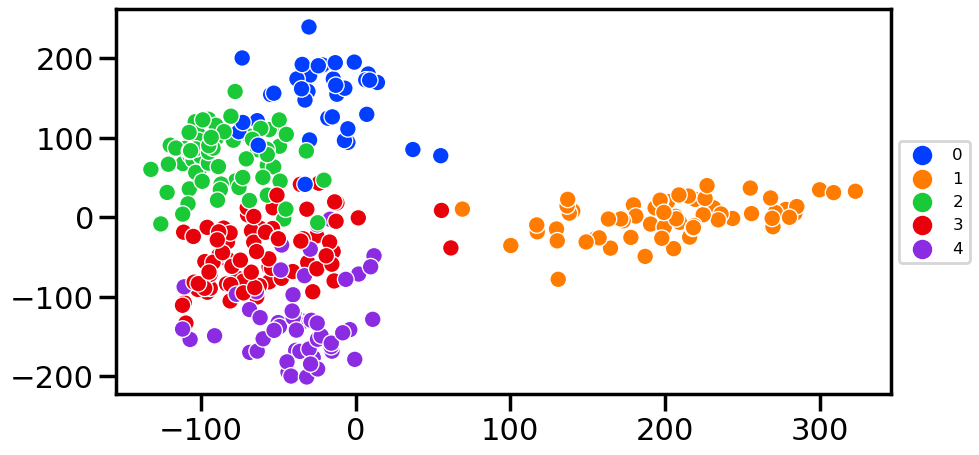

PCA explained variance [0.13785045 0.22932835 0.28970507 0.32243163 0.34542491 0.36526569
 0.38060358 0.39520081 0.408551   0.42052748]


In [31]:
from sklearn.decomposition import PCA

# Create a PCA object with the number of components you want to keep
n_components = 10
pca = PCA(n_components=n_components)
pcs = pca.fit_transform(expr_df_filtered)
pc1_values = pcs[:, 0]
pc2_values = pcs[:, 1]

sns.set_context('poster')
plt.figure(figsize=(10, 5))
g = sns.scatterplot(x=pc1_values, y=pc2_values, hue=cluster_labels, palette='bright')
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, fontsize=12)
plt.show()
print('PCA explained variance', pca.explained_variance_ratio_.cumsum())

### Run basket trial analysis

In [32]:
basket_names

array(['Biliary Tract', 'Bladder/Urinary Tract', 'Bone', 'Bowel',
       'Breast', 'Cervix', 'CNS/Brain', 'Esophagus/Stomach',
       'Head and Neck', 'Kidney', 'Liver', 'Lung', 'Lymphoid', 'Myeloid',
       'Other', 'Ovary/Fallopian Tube', 'Pancreas',
       'Peripheral Nervous System', 'Pleura', 'Prostate', 'Skin',
       'Soft Tissue', 'Thyroid', 'Uterus'], dtype=object)

In [33]:
K = len(basket_names)
K, C

(24, 5)

#### Create clustering dataframe

In [34]:
class_labels = classes.tissues.values
len(class_labels), len(cluster_labels)

(299, 299)

In [35]:
def get_cluster_df_by_cluster(class_labels, cluster_labels):
    # for each cluster, count the proportions of basket containing its member
    unique_clusters = np.unique(cluster_labels)
    unique_classes = np.unique(class_labels)
    cluster_df = pd.DataFrame(index=unique_classes)

    for i, cluster in enumerate(unique_clusters):
        cluster_members = class_labels[cluster_labels == cluster]
        unique_class_counts, counts = np.unique(cluster_members, return_counts=True)
        proportion = counts / cluster_members.shape[0]
        cluster_df['s_k' + str(cluster)] = pd.Series(dict(zip(unique_class_counts, proportion)))

    cluster_df = cluster_df.fillna(0)
    return cluster_df

In [36]:
def get_cluster_df_by_basket(class_labels, cluster_labels):
    # for each basket, count the proportions of clusters containing its member
    
    unique_class_labels = np.unique(class_labels)  # get the unique class labels
    unique_cluster_labels = np.unique(cluster_labels)  # get the unique cluster labels

    result = {class_label: {cluster_label: 0 for cluster_label in unique_cluster_labels} for class_label in unique_class_labels}

    for class_label in unique_class_labels:
        indices = np.where(class_labels == class_label)[0]  # get the indices of the elements with this class label
        total_members = len(indices)  # get the total number of members of this class
        for cluster_label in np.unique(cluster_labels):
            count = np.sum(cluster_labels[indices] == cluster_label)  # count how many members are in this cluster
            proportion = count / total_members  # compute the proportion of members in this cluster
            result[class_label][cluster_label] = proportion

    df = pd.DataFrame(result)
    df = df.transpose()
    df.index = unique_class_labels
    df.columns = ['sk_%d' % cl for cl in unique_cluster_labels]
    return df

In [37]:
cluster_df = get_cluster_df_by_basket(class_labels, cluster_labels)
cluster_df

,sk_0,sk_1,sk_2,sk_3,sk_4
Biliary Tract,0.250000,0.000000,0.750000,0.000000,0.000000
Bladder/Urinary Tract,0.000000,0.000000,0.600000,0.400000,0.000000
Bone,0.000000,0.000000,0.000000,0.360000,0.640000
Bowel,0.785714,0.000000,0.142857,0.035714,0.035714
Breast,0.272727,0.000000,0.727273,0.000000,0.000000
CNS/Brain,0.000000,0.000000,0.000000,0.928571,0.071429
Cervix,0.000000,0.000000,0.692308,0.153846,0.153846
Esophagus/Stomach,0.315789,0.000000,0.526316,0.157895,0.000000
Head and Neck,0.000000,0.000000,0.750000,0.250000,0.000000
Kidney,0.000000,0.000000,0.000000,1.000000,0.000000


<AxesSubplot: >

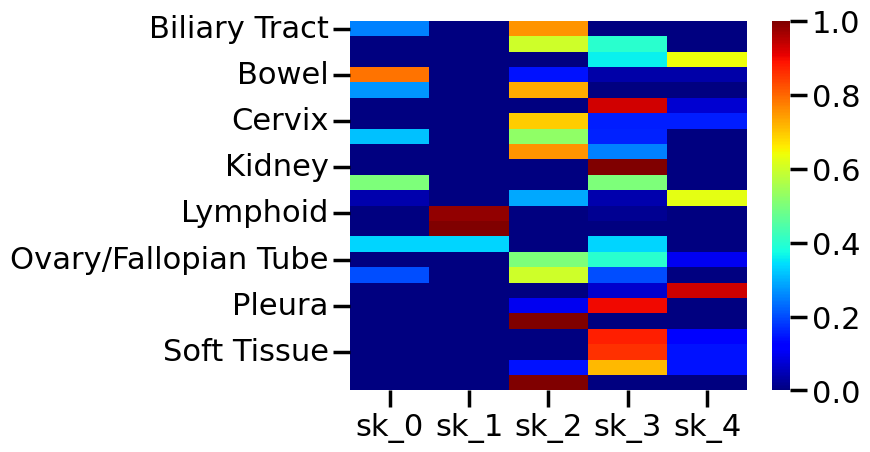

In [38]:
sns.heatmap(cluster_df, cmap='jet')

#### Add the counts of responsive patients for each basket

In [39]:
n_trial_df = df_filtered.groupby('tissues').count().drop(columns=['responses'])
n_trial_df.rename(columns={'samples': 'n_trial'}, inplace=True)
n_trial_df

,n_trial
tissues,
Biliary Tract,4
Bladder/Urinary Tract,5
Bone,25
Bowel,28
Breast,11
CNS/Brain,14
Cervix,13
Esophagus/Stomach,19
Head and Neck,16


In [40]:
aac_thresh = df['responses'].mean()

n_success_df = df_filtered[df_filtered['responses'] < aac_thresh].groupby('tissues').count().drop(columns=['responses'])
n_success_df.rename(columns={'samples': 'n_success'}, inplace=True)
n_success_df

,n_success
tissues,
Biliary Tract,3
Bladder/Urinary Tract,2
Bone,14
Bowel,15
Breast,5
CNS/Brain,6
Cervix,9
Esophagus/Stomach,12
Head and Neck,9


In [41]:
data_df = pd.concat([cluster_df, n_success_df, n_trial_df], axis=1)
data_df

,sk_0,sk_1,sk_2,sk_3,sk_4,n_success,n_trial
Biliary Tract,0.250000,0.000000,0.750000,0.000000,0.000000,3,4
Bladder/Urinary Tract,0.000000,0.000000,0.600000,0.400000,0.000000,2,5
Bone,0.000000,0.000000,0.000000,0.360000,0.640000,14,25
Bowel,0.785714,0.000000,0.142857,0.035714,0.035714,15,28
Breast,0.272727,0.000000,0.727273,0.000000,0.000000,5,11
CNS/Brain,0.000000,0.000000,0.000000,0.928571,0.071429,6,14
Cervix,0.000000,0.000000,0.692308,0.153846,0.153846,9,13
Esophagus/Stomach,0.315789,0.000000,0.526316,0.157895,0.000000,12,19
Head and Neck,0.000000,0.000000,0.750000,0.250000,0.000000,9,16
Kidney,0.000000,0.000000,0.000000,1.000000,0.000000,5,5


In [42]:
n_burn_in = int(1E3)
n_sample = int(1E3)
target_accept = 0.99

### Run simple model

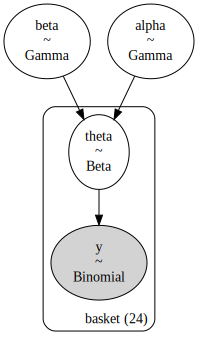

In [43]:
model_simple = get_model_simple(data_df)
pm.model_to_graphviz(model_simple)

In [44]:
with model_simple:
    trace_simple = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


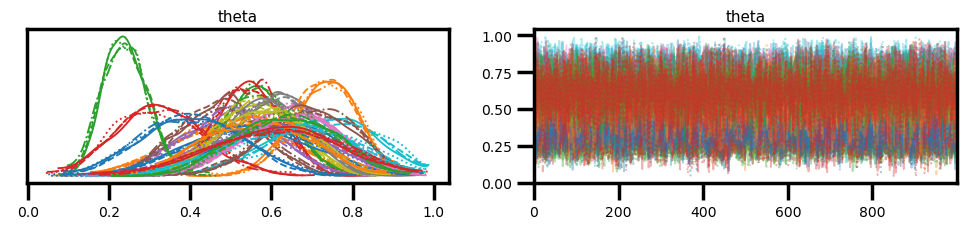

In [45]:
az.plot_trace(trace_simple, var_names=['theta']);

In [46]:
stacked_simple = az.extract(trace_simple)

array([0.62442719, 0.50115006, 0.56147914, 0.54304365, 0.49977388,
       0.4753515 , 0.63869539, 0.61149168, 0.56237889, 0.72383812,
       0.54821984, 0.73045888, 0.24028858, 0.32844917, 0.5914834 ,
       0.69138541, 0.64965182, 0.58608371, 0.5824542 , 0.64464822,
       0.4064803 , 0.56400284, 0.63168768, 0.60783833])

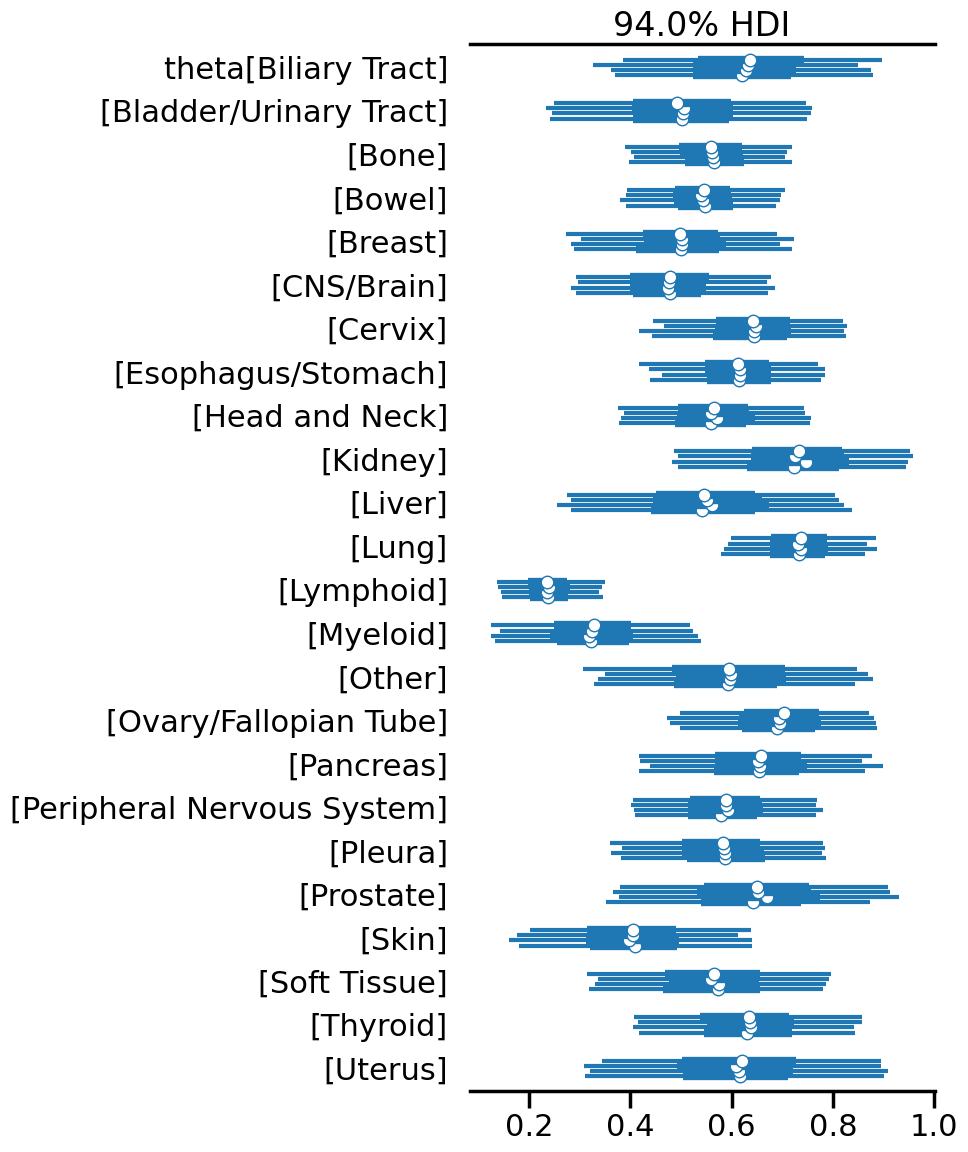

In [47]:
az.plot_forest(trace_simple, var_names='theta')

predicted = np.mean(stacked_simple.theta.values, axis=1)
predicted

#### Run BHM

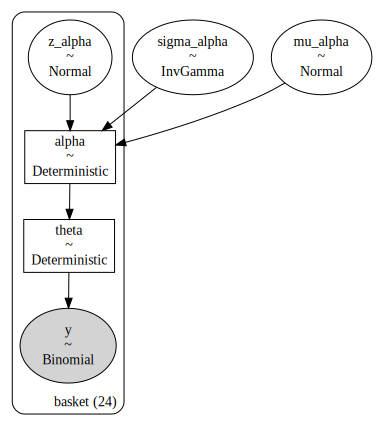

In [48]:
model_bhm_nc = get_model_bhm_nc(data_df)
pm.model_to_graphviz(model_bhm_nc)

In [49]:
with model_bhm_nc:
    trace_bhm_nc = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_alpha, mu_alpha, sigma_alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


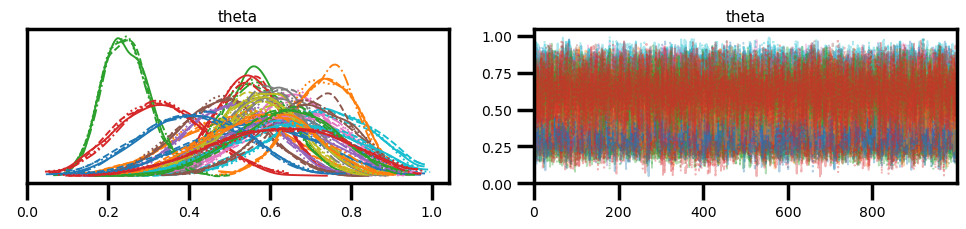

In [50]:
az.plot_trace(trace_bhm_nc, var_names=['theta']);

In [51]:
stacked_bhm_nc = az.extract(trace_bhm_nc)

array([ 0.57166824,  0.0124206 ,  0.2615875 ,  0.17995195,  0.01738826,
       -0.08600138,  0.62759546,  0.46850083,  0.27497849,  1.06555671,
        0.24023475,  1.03804108, -1.14897218, -0.73826052,  0.42502983,
        0.85948676,  0.69616307,  0.38001284,  0.35041089,  0.71440527,
       -0.38510848,  0.3154302 ,  0.60229435,  0.53618953])

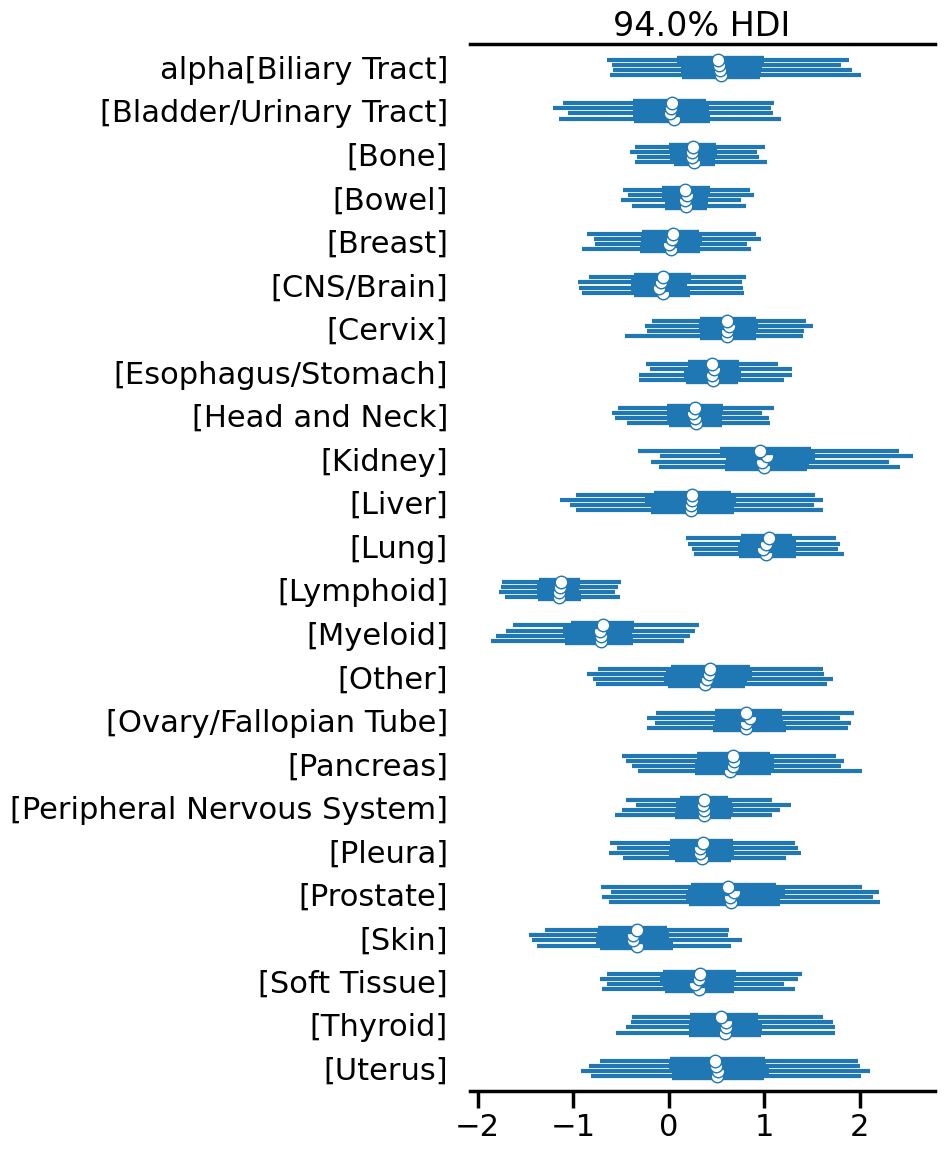

In [52]:
az.plot_forest(trace_bhm_nc, var_names='alpha')

predicted = np.mean(stacked_bhm_nc.alpha.values, axis=1)
predicted

array([0.62614512, 0.50336708, 0.56305866, 0.5436443 , 0.50426332,
       0.47958348, 0.64498563, 0.61071643, 0.56551054, 0.72297514,
       0.55380055, 0.73057425, 0.24564792, 0.33389259, 0.59517146,
       0.69051987, 0.65455209, 0.58990576, 0.58185463, 0.65207145,
       0.41197262, 0.57293153, 0.63608022, 0.61561104])

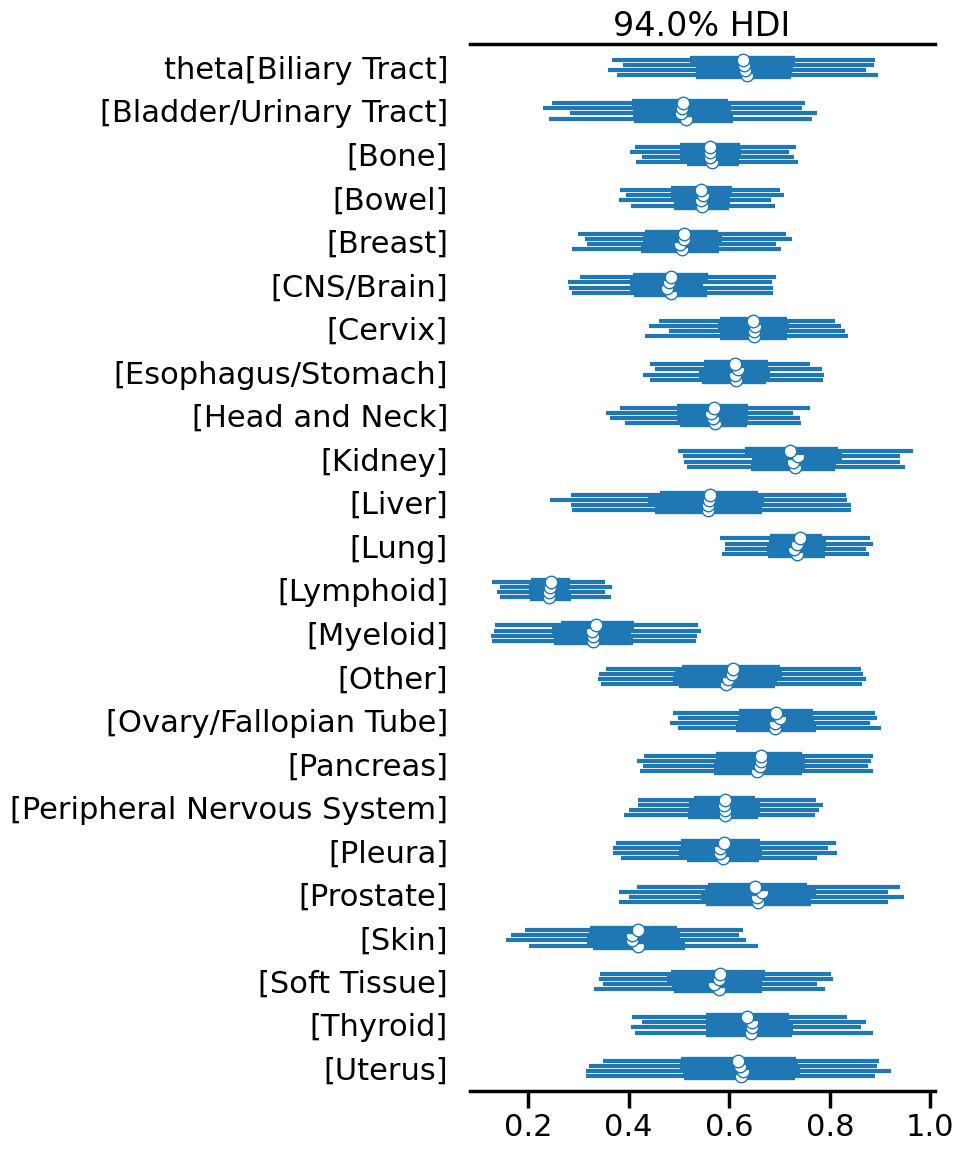

In [53]:
az.plot_forest(trace_bhm_nc, var_names='theta')

predicted = np.mean(stacked_bhm_nc.theta.values, axis=1)
predicted

#### Run logistic regression

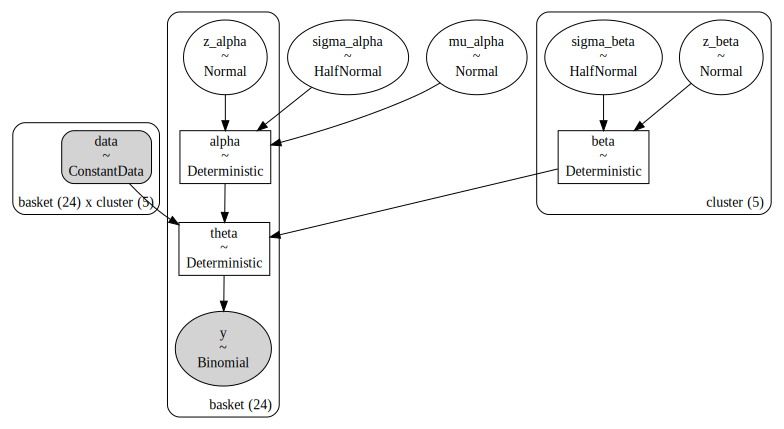

In [54]:
model_logres_nc = get_model_logres_nc(data_df)
pm.model_to_graphviz(model_logres_nc)

In [55]:
with model_logres_nc:
    trace_logres_nc = pm.sample(n_sample, tune=n_burn_in, idata_kwargs={'log_likelihood': True}, target_accept=target_accept)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_alpha, z_beta, mu_alpha, sigma_alpha, sigma_beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 65 seconds.


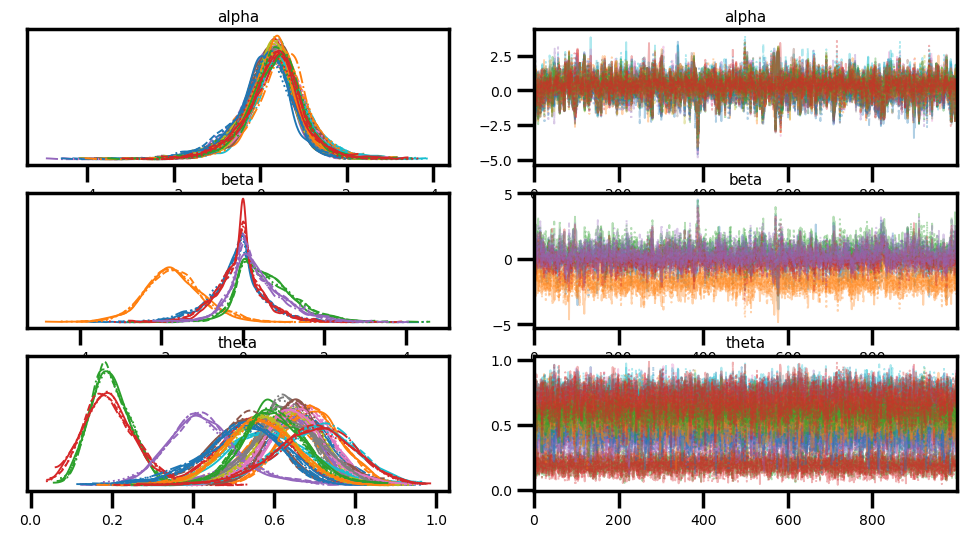

In [56]:
az.plot_trace(trace_logres_nc, var_names=['alpha', 'beta', 'theta']);

In [57]:
stacked_logres_nc = az.extract(trace_logres_nc)

array([0.29844314, 0.14938968, 0.1959784 , 0.23069887, 0.11006824,
       0.14113357, 0.29146714, 0.27247597, 0.17311706, 0.47395508,
       0.25107608, 0.46263914, 0.22728871, 0.22942537, 0.34007208,
       0.39313268, 0.34266855, 0.23832887, 0.28599751, 0.34179013,
       0.05739059, 0.27432559, 0.33976378, 0.31249141])

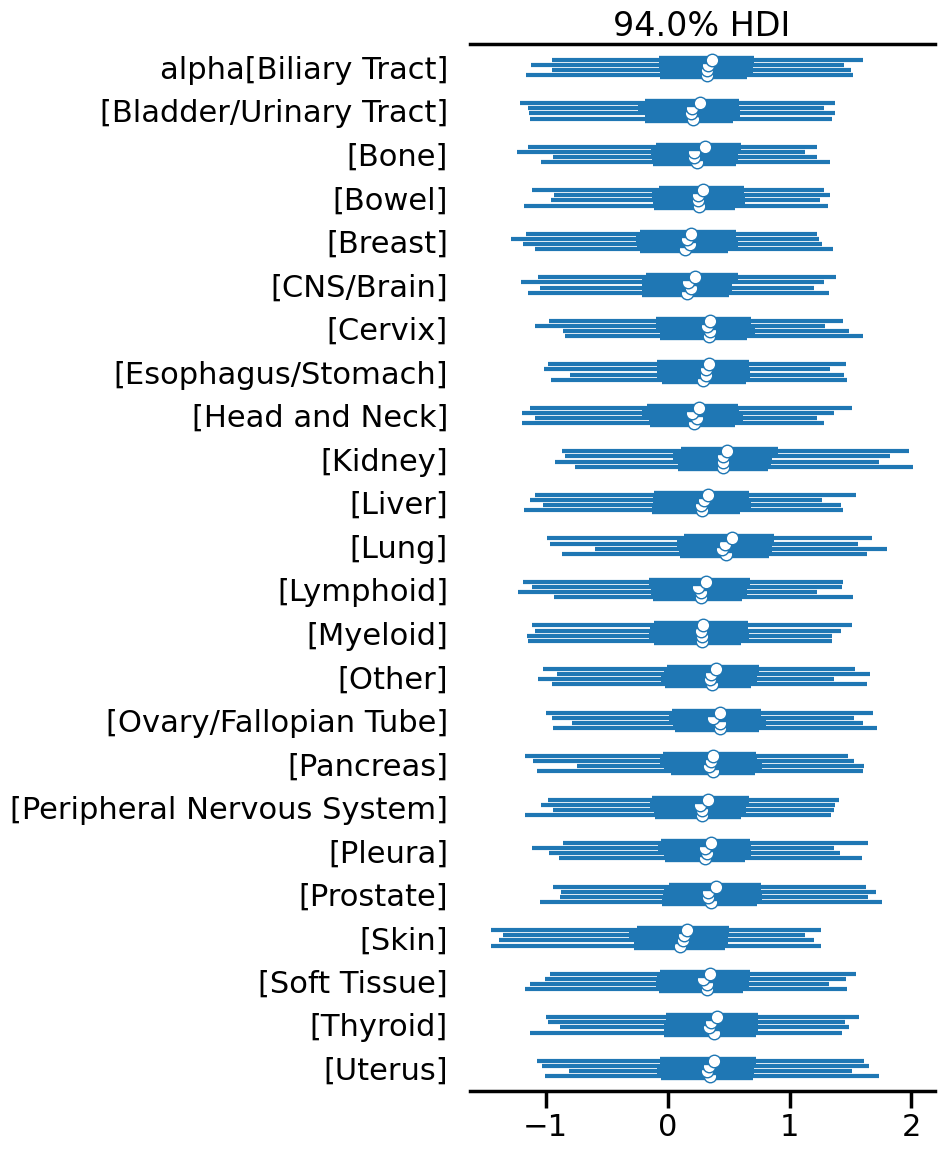

In [58]:
az.plot_forest(trace_logres_nc, var_names='alpha')

predicted = np.mean(stacked_logres_nc.alpha.values, axis=1)
predicted

array([-0.13948661, -1.68800144,  0.55911773, -0.06741859,  0.34528019])

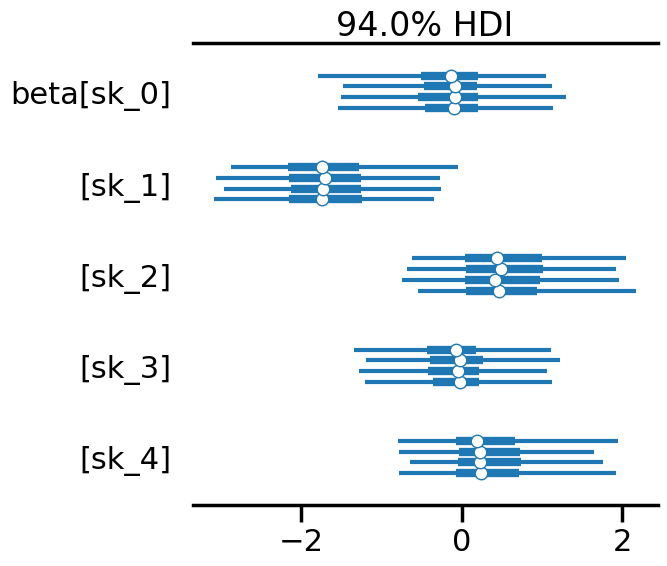

In [59]:
az.plot_forest(trace_logres_nc, var_names='beta')

predicted = np.mean(stacked_logres_nc.beta.values, axis=1)
predicted

array([0.65824799, 0.60925915, 0.59489862, 0.55105846, 0.61392315,
       0.52523837, 0.66859379, 0.62264413, 0.63644949, 0.59325187,
       0.53514714, 0.69173609, 0.19812536, 0.19765566, 0.42939552,
       0.65910418, 0.64844982, 0.63071315, 0.56756484, 0.7001557 ,
       0.51089174, 0.56383789, 0.60031057, 0.69405959])

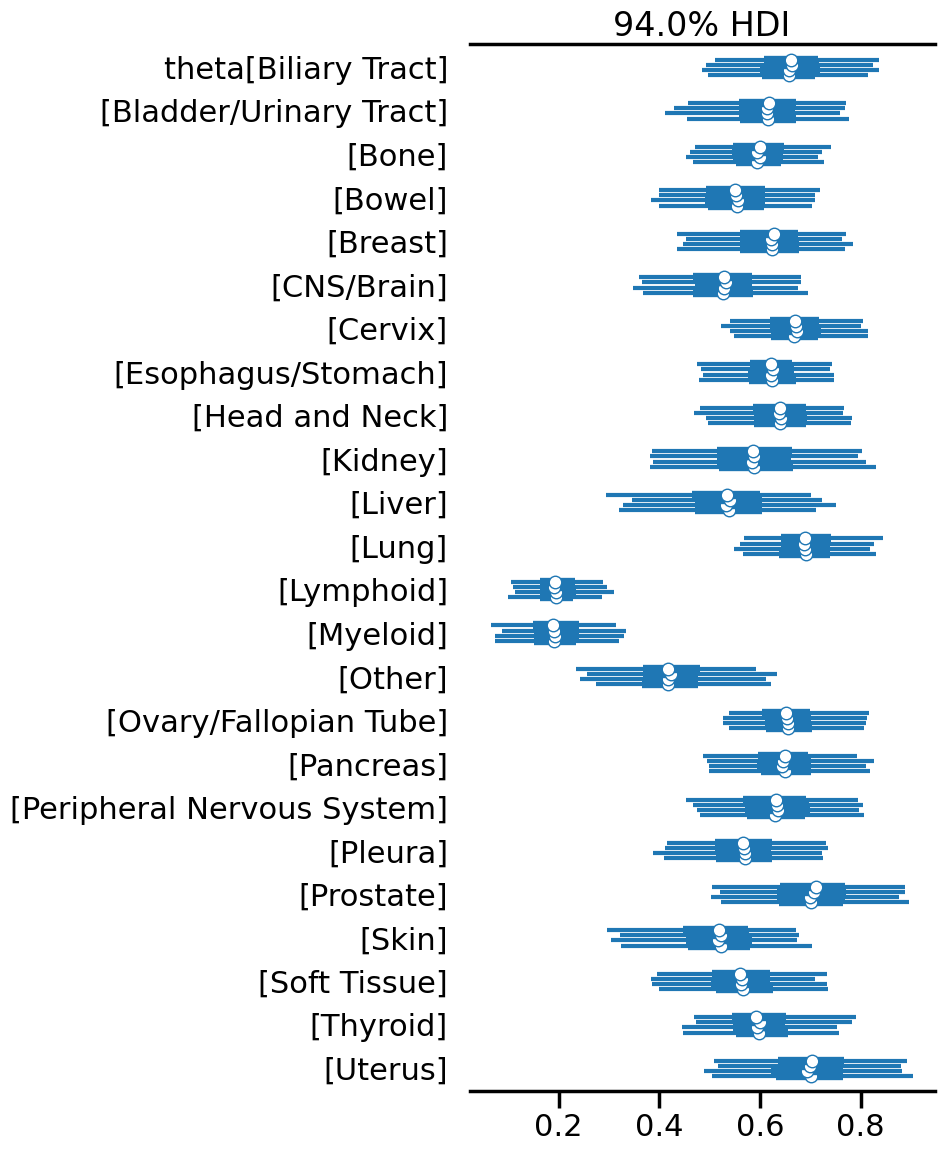

In [60]:
az.plot_forest(trace_logres_nc, var_names='theta')

predicted = np.mean(stacked_logres_nc.theta.values, axis=1)
predicted

#### Model fit

In [61]:
loo_simple = az.loo(trace_simple)
loo_simple

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 24 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -48.92     4.06
p_loo       11.43        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        5   20.8%
 (0.5, 0.7]   (ok)          9   37.5%
   (0.7, 1]   (bad)         9   37.5%
   (1, Inf)   (very bad)    1    4.2%

In [62]:
loo_bhm_nc = az.loo(trace_bhm_nc)
loo_bhm_nc

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 24 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -49.44     4.82
p_loo       11.86        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        8   33.3%
 (0.5, 0.7]   (ok)         11   45.8%
   (0.7, 1]   (bad)         4   16.7%
   (1, Inf)   (very bad)    1    4.2%

In [63]:
loo_logres_nc = az.loo(trace_logres_nc)
loo_logres_nc

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 posterior samples and 24 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -44.87     3.66
p_loo        6.27        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       13   54.2%
 (0.5, 0.7]   (ok)          7   29.2%
   (0.7, 1]   (bad)         4   16.7%
   (1, Inf)   (very bad)    0    0.0%

In [64]:
ic = 'loo'
df_comp_loo = az.compare({
    'simple': trace_simple, 
    'bhm': trace_bhm_nc,
    'logres': loo_logres_nc,
}, ic=ic)
df_comp_loo

/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/anaconda3/envs/pyBasket/lib/python3.11/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
logres,0,-44.870758,6.271527,0.000000,1.000000e+00,3.660947,0.000000,True,log
simple,1,-48.924754,11.427974,4.053996,5.384582e-15,4.059098,2.717888,True,log
bhm,2,-49.440881,11.861197,4.570124,0.000000e+00,4.821651,3.521888,True,log


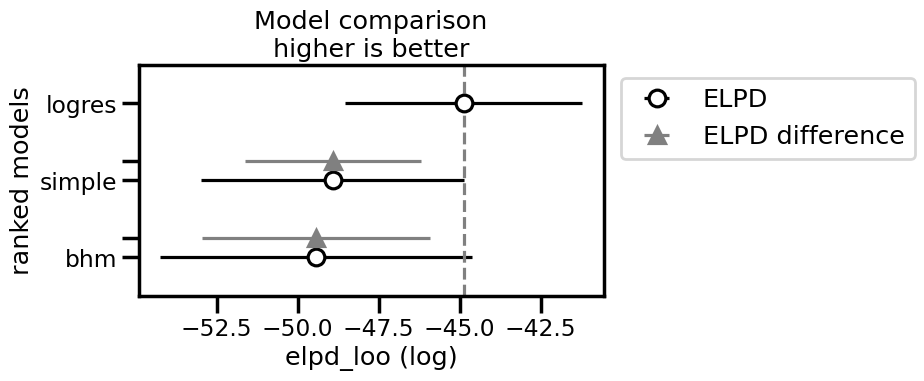

In [65]:
az.plot_compare(df_comp_loo);